In [1]:
!pip install torch==1.12.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 1.9 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling torch-2.0.0+cu118:
      Successfully uninstalled torch-2.0.0+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.15.1+cu118 requires torch==2.0.0, but you have torch 1.12.1 which is incompatible.
torchtext 0.15.1 requires torch==2.0.0, but you have torch 1.12.1 which is incompatible.
torchdata 0.6.0 requires torch==2.0.0, but you have torch 1.12.1 which is incompatible.
torchaudio 2.0.1+cu118 requires torch==2.0.0, but you have torch 1.12.1 which is incompatible.


In [2]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 15.9 MB/s eta 0:00:00


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
from torchmetrics.classification import MulticlassAccuracy
from torchmetrics import Accuracy

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104impl8GPUTrace13gpuTraceStateE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [5]:
batch_size = 10000

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [7]:
dict1 = unpickle(file='./data/cifar-10-batches-py/data_batch_1')
dict2 = unpickle(file='./data/cifar-10-batches-py/data_batch_2')
dict3 = unpickle(file='./data/cifar-10-batches-py/data_batch_3')
dict4 = unpickle(file='./data/cifar-10-batches-py/data_batch_4')
dict5 = unpickle(file='./data/cifar-10-batches-py/data_batch_5')
dict_test = unpickle(file='./data/cifar-10-batches-py/test_batch')
train_x1 = torch.tensor(dict1[b'data'])
train_y1 = torch.tensor(dict1[b'labels'])
train_x2 = torch.tensor(dict2[b'data'])
train_y2 = torch.tensor(dict2[b'labels'])
train_x3 = torch.tensor(dict3[b'data'])
train_y3 = torch.tensor(dict3[b'labels'])
train_x4 = torch.tensor(dict4[b'data'])
train_y4 = torch.tensor(dict4[b'labels'])
train_x5 = torch.tensor(dict5[b'data'])
train_y5 = torch.tensor(dict5[b'labels'])
test_x = torch.tensor(dict_test[b'data'])
test_y = torch.tensor(dict_test[b'labels'])
train_x = torch.cat((train_x1, train_x2, train_x3, train_x4, train_x5), dim=0)
train_y = torch.cat((train_y1, train_y2, train_y3, train_y4, train_y5), dim=0)
train_x = torch.reshape(train_x, (50000, 3, 32, 32))/255
test_x = torch.reshape(test_x, (10000, 3, 32, 32))/255
train_y_framed = torch.nn.functional.one_hot(train_y.clone().detach(), num_classes=10)
train_y_framed = torch.tensor(train_y_framed, dtype=torch.float)
test_y_framed = torch.nn.functional.one_hot(test_y.clone().detach(), num_classes=10)
test_y_framed = torch.tensor(test_y_framed, dtype=torch.float)

<ipython-input-7-c4e2bf4b2f82>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y_framed = torch.tensor(train_y_framed, dtype=torch.float)
<ipython-input-7-c4e2bf4b2f82>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_y_framed = torch.tensor(test_y_framed, dtype=torch.float)


In [8]:
class Model(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.con1 = torch.nn.Conv2d(3,32,(3,3),stride=(1,1), padding=(1,1), padding_mode='zeros')
        self.con2 = torch.nn.Conv2d(32,64,(5,5),stride=(1,1), padding=(1,1), padding_mode='zeros')
        self.con3 = torch.nn.Conv2d(64,64,(3,3),stride=(1,1), padding=(1,1), padding_mode='zeros')
        self.pool = torch.nn.MaxPool2d((2,2), stride=(2,2), padding=0)
        self.f1 = torch.nn.Linear(64*7*7, 64)
        self.f2 = torch.nn.Linear(64, 10)
        self.soft_max = torch.nn.LogSoftmax(dim=1)
        self.rel = torch.nn.functional.relu

    def forward(self, x):
        x = self.con1(x)
        x = self.rel(x)
        x = self.pool(x)
        x = self.con2(x)
        x = self.rel(x)
        x = self.pool(x)
        x = self.con3(x)
        x = self.rel(x)
        x = torch.reshape(x, (-1, 64*7*7))
        x = self.f1(x)
        x = self.rel(x)
        x = self.f2(x)
        predict = self.soft_max(x)
        return predict

In [9]:
epochs = 20
batch = 32
n_batches = 1562
metric = Accuracy(task="multiclass", num_classes=10).to('cuda:0')

In [10]:
mymodel = Model().to('cuda:0')
criterion = nn.CrossEntropyLoss()
# kl_criterion = torch.nn.KLDivLoss(reduction="batchmean", log_target=True)
optimizer = optim.Adam(mymodel.parameters(), lr=0.001)
val_loss = torch.empty(epochs)
train_loss = torch.empty(epochs)
valb = 32
acc_v = np.zeros(epochs)
acc_t = np.zeros(epochs)
for epoch in range(epochs):
  rloss = 0
  acc = 0
  count = 0
  vloss = 0
  for b in range(n_batches):
  # for b in range(10):
    xbatch = train_x[(b)*batch:(b+1)*(batch)].to('cuda:0')
    ybatch = train_y_framed[(b)*batch:(b+1)*(batch)].to('cuda:0')
    predict = mymodel.forward(xbatch)
    loss = criterion(predict,ybatch)
    optimizer.zero_grad()
    loss.backward()
    rloss+=loss.item()
    optimizer.step()
  predict_val_v = mymodel.forward(test_x[:2000].to('cuda:0'))
  predict_val_t = mymodel.forward(train_x[:2000].to('cuda:0'))
  pred_labels_v = torch.argmax(predict_val_v, dim=1)
  pred_labels_t = torch.argmax(predict_val_t, dim=1)
  acc_t[epoch]= metric(pred_labels_t, train_y[:2000].to('cuda:0'))
  acc_v[epoch]=metric(pred_labels_v, test_y[:2000].to('cuda:0'))
  print(f'TRAIN_ACC: {acc_t[epoch]}')
  print(f'VAL ACC: {acc_v[epoch]}')
  loss2 = criterion(predict_val_v, test_y_framed[:2000].to('cuda:0')).item()
  print(f"Training Loss after epoch {epoch+1}: {rloss}")
  train_loss[epoch] = rloss
  val_loss[epoch] = loss2
  # Validation loss 
  print(f"Validation Loss after epoch {epoch+1}: {loss2}")
  # p1 = torch.argmax(predic,dim=1)
  # p2 = torch.argmax(test_y_framed[:500], dim=1)
  # count = torch.sum(p2)
  # val_accs[epoch] = torch.sum(torch.where(p1==p2,1,0))/count
  # print(f'Validation acc after epoch {epoch+1}: {val_accs[epoch]}')


TRAIN_ACC: 0.5460000038146973
VAL ACC: 0.546500027179718
Training Loss after epoch 1: 2452.763298869133
Validation Loss after epoch 1: 1.278201937675476
TRAIN_ACC: 0.628000020980835
VAL ACC: 0.6060000061988831
Training Loss after epoch 2: 1887.3794855475426
Validation Loss after epoch 2: 1.114057183265686
TRAIN_ACC: 0.6775000095367432
VAL ACC: 0.6455000042915344
Training Loss after epoch 3: 1621.8367682099342
Validation Loss after epoch 3: 0.9958231449127197
TRAIN_ACC: 0.7139999866485596
VAL ACC: 0.6639999747276306
Training Loss after epoch 4: 1437.3560784757137
Validation Loss after epoch 4: 0.9445059895515442
TRAIN_ACC: 0.7335000038146973
VAL ACC: 0.6794999837875366
Training Loss after epoch 5: 1301.6402918994427
Validation Loss after epoch 5: 0.9132432341575623
TRAIN_ACC: 0.7455000281333923
VAL ACC: 0.6865000128746033
Training Loss after epoch 6: 1193.1707688719034
Validation Loss after epoch 6: 0.9047917723655701
TRAIN_ACC: 0.7555000185966492
VAL ACC: 0.6850000023841858
Training Lo

In [11]:
metric = Accuracy(task="multiclass", num_classes=10).to('cuda:0')
acc_metric = MulticlassAccuracy(num_classes=10, average=None).to('cuda:0')
# finalpred = mymodel.forward(test_x[:1000])
pred_labels = torch.argmax(predict_val_v, dim=1)
classaccs = acc_metric(pred_labels, test_y[:2000].to('cuda:0'))
accfinal = metric(pred_labels, test_y[:2000].to('cuda:0'))
print(accfinal)
print(classaccs)

tensor(0.6450, device='cuda:0')
tensor([0.5561, 0.7525, 0.4359, 0.5528, 0.5606, 0.6378, 0.7593, 0.7409, 0.7189,
        0.7143], device='cuda:0')


In [12]:
print(acc_t)
print(acc_v)

[0.546      0.62800002 0.67750001 0.71399999 0.7335     0.74550003
 0.75550002 0.77100003 0.79799998 0.80599999 0.80250001 0.8125
 0.81349999 0.82300001 0.824      0.7845     0.77450001 0.77999997
 0.83450001 0.80849999]
[0.54650003 0.60600001 0.6455     0.66399997 0.67949998 0.68650001
 0.685      0.685      0.68800002 0.69300002 0.69550002 0.68550003
 0.68550003 0.66900003 0.6645     0.64749998 0.63349998 0.62349999
 0.6595     0.64499998]


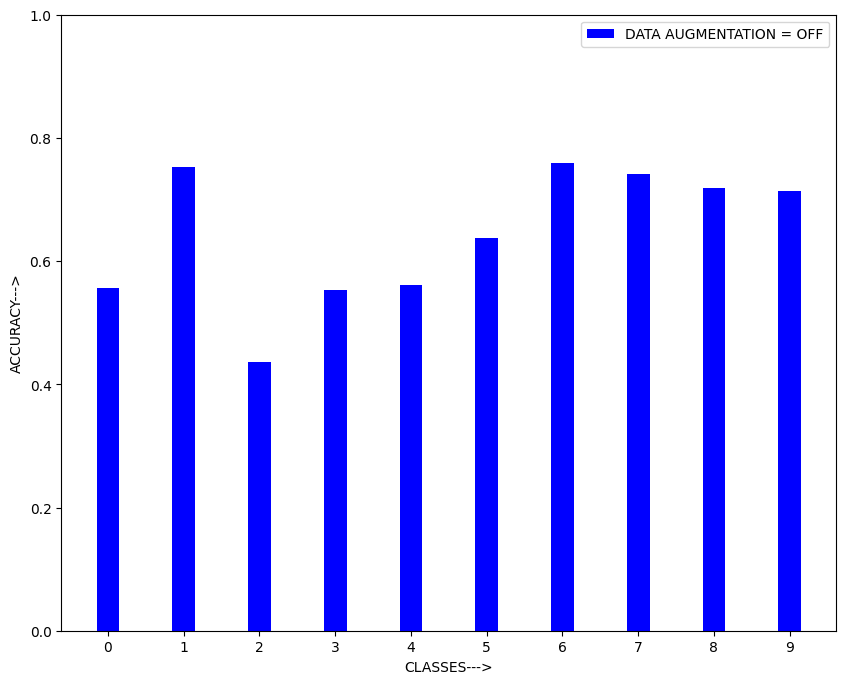

In [13]:
plt.figure(figsize=(10,8))
plt.xlabel('CLASSES--->')
plt.ylabel('ACCURACY--->')
plt.xticks(np.arange(0,10))
plt.ylim(0,1)
plt.bar(np.arange(0,10),classaccs.to('cpu'),color='blue',label='DATA AUGMENTATION = OFF',width=0.3)
plt.legend()
plt.show()

In [14]:
print(train_loss)
print(val_loss)
train_loss = train_loss/499.84
val_loss = val_loss/20
print(train_loss)
print(val_loss)
tloss = train_loss.detach().numpy()
vloss = val_loss.detach().numpy()

tensor([2452.7632, 1887.3795, 1621.8368, 1437.3561, 1301.6403, 1193.1708,
        1106.6012, 1023.8632,  951.0784,  889.8856,  835.2479,  790.8333,
         747.7883,  713.0890,  665.0524,  626.5083,  592.9620,  559.9713,
         528.3145,  494.1612])
tensor([1.2782, 1.1141, 0.9958, 0.9445, 0.9132, 0.9048, 0.9377, 0.9528, 0.9765,
        1.0120, 1.0783, 1.1239, 1.2248, 1.3173, 1.3603, 1.5729, 1.7972, 1.7992,
        1.7140, 1.9219])
tensor([4.9071, 3.7760, 3.2447, 2.8756, 2.6041, 2.3871, 2.2139, 2.0484, 1.9028,
        1.7803, 1.6710, 1.5822, 1.4961, 1.4266, 1.3305, 1.2534, 1.1863, 1.1203,
        1.0570, 0.9886])
tensor([0.0639, 0.0557, 0.0498, 0.0472, 0.0457, 0.0452, 0.0469, 0.0476, 0.0488,
        0.0506, 0.0539, 0.0562, 0.0612, 0.0659, 0.0680, 0.0786, 0.0899, 0.0900,
        0.0857, 0.0961])


In [ ]:
aug_t = np.array([0.5720, 0.6515, 0.6935, 0.7135, 0.7445, 0.7675, 0.7685, 0.7675, 0.7785,
        0.7865, 0.8365, 0.8225, 0.7910, 0.8280, 0.8450, 0.8425, 0.8295, 0.8370,
        0.8660, 0.8795, 0.8715, 0.8870, 0.8805, 0.8845, 0.8790, 0.8970, 0.9090,
        0.8815, 0.9205, 0.9160, 0.9020, 0.9175, 0.9260, 0.9190, 0.9255])
aug_v = np.array([0.5605, 0.6355, 0.6760, 0.6795, 0.6850, 0.6825, 0.6800, 0.6700, 0.6680,
        0.6690, 0.6700, 0.6655, 0.6445, 0.6510, 0.6570, 0.6515, 0.6375, 0.6415,
        0.6470, 0.6480, 0.6455, 0.6385, 0.6500, 0.6575, 0.6320, 0.6475, 0.6440,
        0.6425, 0.6565, 0.6580, 0.6430, 0.6510, 0.6580, 0.6490, 0.6515])

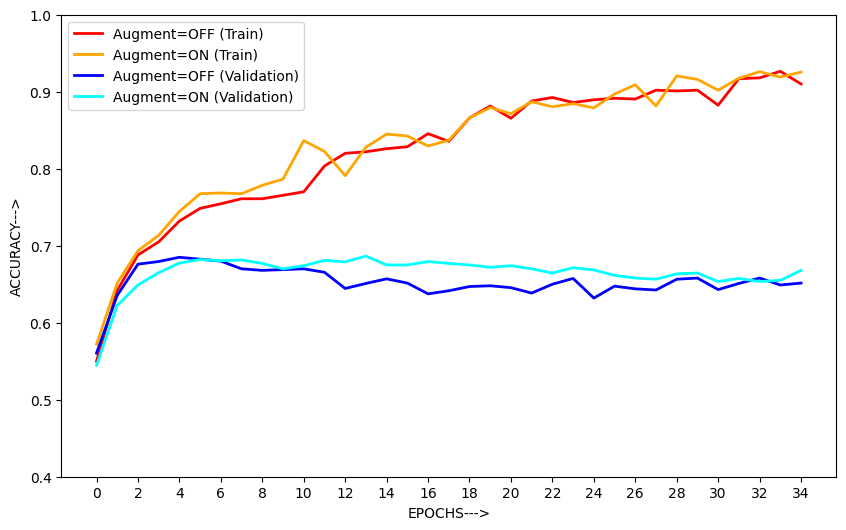

In [ ]:
#CODE PLOT:
plt.figure(figsize=(10,6))
plt.xlabel('EPOCHS--->')
plt.ylabel('ACCURACY--->')
epoch_arr = np.arange(0,35)
epoch_ticks = np.arange(0,37, 2)
plt.xticks(epoch_ticks)
plt.ylim(0.4,1)
plt.plot(epoch_arr, acc_t, 'r', label='Augment=OFF (Train)', linewidth=2)
plt.plot(epoch_arr, aug_t,'orange',label='Augment=ON (Train)',linewidth=2)
plt.plot(epoch_arr, aug_v,'b',label='Augment=OFF (Validation)',linewidth=2)
plt.plot(epoch_arr, acc_v, 'cyan', label='Augment=ON (Validation)', linewidth=2)
plt.legend()
plt.show()

In [ ]:
tl1 = np.array([4.6798, 3.3941, 2.8265, 2.4660, 2.1989, 1.9609, 1.7747, 1.6242, 1.4892,
        1.3689, 1.2531, 1.1638, 1.0528, 1.0081, 0.8814, 0.8194, 0.7478, 0.7082,
        0.6791, 0.6537, 0.6183, 0.5833, 0.5416, 0.5054, 0.5074, 0.4823, 0.4684,
        0.4659, 0.4149, 0.4265, 0.4078, 0.3694, 0.3801, 0.3687, 0.3771, 0.3576,
        0.3460, 0.3161, 0.3150, 0.3330])
vl1 = np.array([0.1161, 0.0948, 0.0859, 0.0852, 0.0833, 0.0834, 0.0873, 0.0989, 0.1098,
        0.1100, 0.1288, 0.1259, 0.1339, 0.1322, 0.1391, 0.1521, 0.1569, 0.1839,
        0.1775, 0.1735, 0.1900, 0.1962, 0.1942, 0.1888, 0.1935, 0.2044, 0.2132,
        0.2154, 0.2212, 0.2347, 0.2302, 0.2399, 0.2324, 0.2558, 0.2346, 0.2348,
        0.2466, 0.2469, 0.2581, 0.2616])
tl2 = np.array([4.6784, 3.4763, 2.9480, 2.5952, 2.3215, 2.1208, 1.9300, 1.7683, 1.6207,
        1.5087, 1.4010, 1.3048, 1.2065, 1.0950, 1.0352, 0.9813, 0.9186, 0.8465,
        0.7616, 0.7253])
vl2 = np.array([0.1203, 0.0993, 0.0892, 0.0878, 0.0908, 0.0926, 0.0910, 0.0901, 0.0977,
        0.1056, 0.1151, 0.1277, 0.1301, 0.1469, 0.1453, 0.1558, 0.1589, 0.1636,
        0.1656, 0.1696])


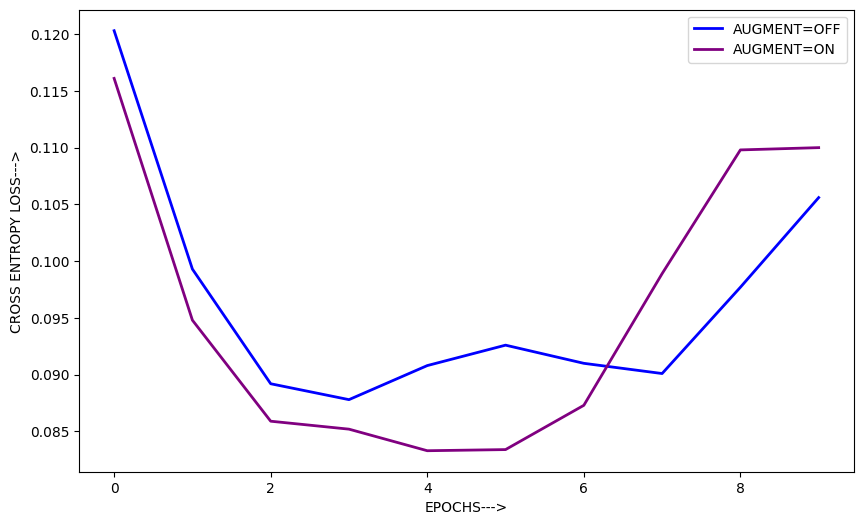

In [ ]:
plt.figure(figsize=(10,6))
plt.xlabel('EPOCHS--->')
plt.ylabel('CROSS ENTROPY LOSS--->')
epoch_arr = np.arange(0,10)
epoch_ticks = np.arange(0,12,2)
plt.xticks(epoch_ticks)
# plt.ylim(0,3)
# plt.plot(epoch_arr, tloss, 'r', label='AUGMENT=OFF', linewidth=2)
plt.plot(epoch_arr, vl2[:10], 'b', label='AUGMENT=OFF', linewidth=2)
# plt.plot(epoch_arr, tl1[:20], 'lime', label='AUGMENT=ON', linewidth=2)
plt.plot(epoch_arr, vl1[:10], 'purple', label='AUGMENT=ON', linewidth=2)
plt.legend()
plt.show()